# Prerequisites

In [ ]:
# Install the required pip packages in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install numpy pandas seaborn matplotlib torch transformers spacy sklearn

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
torch.manual_seed(2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading and Preprocessing

In [ ]:
def read_data(path):
    X = []
    y = []
    with open(path) as f:
        for line in f:
            vals = line.split(" OUT: ")
            inp = vals[0][4:].split()
            out = vals[1].split()
            X.append(inp)
            y.append(out)
    return X, y

In [ ]:
def create_vocab(data):
    vocab = set()

    # Add all our words into a set for getting unique ones
    for sent in data:
        for word in sent:
            vocab.add(word)
    return vocab

In [ ]:
SOS_token = 0
EOS_token = 1

In [ ]:
def get_vocab_dicts(vocab : set) -> (dict, dict):    
    # Initialise our dict with a token for padding 
    # and a token for representing words not in our vocab
    w2i = {'<SOS>': 0, '<EOS>': 1, '<UNK>':2}
    n_special_toks = len(w2i)

    # Add all tokens in vocab to dict
    for i, w in enumerate(vocab):
        w2i[w] = i + n_special_toks

    i2w = dict(enumerate(w2i.keys()))

    return w2i, i2w

In [ ]:
# Convert each sentence to a list of indices from the word2idx dict
def numericalize(input, word2idx, vocab):
    out = []

    for sent in input:
        sent_num = []

        sent_num.append(np.float(word2idx['<SOS>']))

        for word in sent:
            if word in vocab:
                sent_num.append(np.float(word2idx[word]))
            else:
                sent_num.append(np.float(word2idx['<UNK>']))
        out.append(sent_num)

        sent_num.append(np.float(word2idx['<EOS>']))
    
    return out

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import Tensor
import numpy as np
import collections

In [ ]:
class SCANData(Dataset):
    def __init__(self, inp, out):
        self.inp = inp
        self.out = out
        self.len = len(inp)

    def __getitem__(self, index):
        i = torch.tensor(self.inp[index], dtype=torch.long, device=device).view(-1, 1)
        o = torch.tensor(self.out[index], dtype=torch.long, device=device).view(-1, 1)
        return i, o

    def __len__(self):
        return self.len

In [ ]:
def create_loaders(0, batch_size=1):
    train_X, train_y = read_data(path_train)
    test_X, test_y = read_data(path_test)

    vocab_inp = create_vocab(train_X)
    vocab_out = create_vocab(train_y)
    w2i_inp, i2w_inp = get_vocab_dicts(vocab_inp)
    w2i_out, i2w_out = get_vocab_dicts(vocab_out)

    train_X_num = numericalize(train_X, w2i_inp, vocab_inp)
    train_y_num = numericalize(train_y, w2i_out, vocab_out)

    test_X_num = numericalize(test_X, w2i_inp, vocab_inp)
    test_y_num = numericalize(test_y, w2i_out, vocab_out)

    dataset_train = SCANData(train_X_num, train_y_num)
    dataset_test = SCANData(test_X_num, test_y_num)

    train_loader = DataLoader(dataset=dataset_train)
    test_loader = DataLoader(dataset=dataset_test)

    return train_loader, test_loader, i2w_inp, i2w_out

# General architecture

Should support the following parameters:
- LSTM vs GRU ✓
- Hidden-size (embedding size always the same) ✓
- Number of layers ✓
- Dropout ✓
- Attention

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size,
                 num_layers=2, dropout=0, rnn_type=nn.LSTM):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.dropout = nn.Dropout(dropout)

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = rnn_type(hidden_size, hidden_size, num_layers=num_layers,
                            dropout=dropout)            

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output = embedded
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def init_hidden(self):
        hn = torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
        if self.rnn_type != nn.LSTM:
            return hn
        cn = torch.zeros(self.num_layers, 1, self.hidden_size, device=device)
        return (hn, cn)


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size,
                 num_layers=2, dropout=0, rnn_type=nn.LSTM):
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.dropout = nn.Dropout(dropout)

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = rnn_type(hidden_size, hidden_size, num_layers=num_layers,
                            dropout=dropout)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs=None):
        # encoder_outputs is unused without attention
        # it's passed simply for api consistency
        output = self.embedding(input).view(1, 1, -1)
        output = self.dropout(output)
        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = self.softmax(self.out(output[0]))
        
        return output, hidden, None

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length,
                 num_layers=2, dropout_p=0, rnn_type=nn.LSTM):
        super(AttnDecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.rnn = rnn_type(hidden_size, hidden_size, num_layers=num_layers,
                            dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        hn = self._select_hidden_state(hidden)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hn[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)

        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        
        #Adding dropout to hidden layer 
        #if self.num_layers == 1: 
        #    hidden = self.dropout(hidden)
          
        #else: 
        #    hidden0 = self.dropout(hidden[0])
        #    hidden1 = self.dropout(hidden[1])

        #    hidden = (hidden0, hidden1)
        
        return output, hidden, attn_weights
    
    def _select_hidden_state(self, hidden):
        if self.rnn_type != nn.LSTM:
            return hidden
        hn, cn = hidden
        return hn

In [ ]:
class EncoderDecoderModel():
    def __init__(self, input_size, output_size, hidden_size, num_layers, max_length,
                 dropout=0, rnn_type=nn.LSTM, attn=False):
        self.attn = attn

        self.encoder = EncoderRNN(input_size, hidden_size, num_layers,
                                  dropout, rnn_type).to(device)
        if attn:
            self.decoder = AttnDecoderRNN(hidden_size, output_size, max_length, num_layers,
                                          dropout, rnn_type).to(device)
        else:
            self.decoder = DecoderRNN(hidden_size, output_size, num_layers,
                                      dropout, rnn_type).to(device)
                                      

# Training and loss plotting

In [ ]:
import time
import math
import random

In [ ]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def plot_losses(losses):
    plt.plot(losses)

In [ ]:
# used for both input and output sequences
# maybe should be different, potential TODO
MAX_LENGTH = 50
teacher_forcing_ratio = 0.5

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, attn,
          encoder_optimizer, decoder_optimizer, criterion, max_length,
          clip=5):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    # Used only for attention decoder
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device) if attn else None

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        if attn:
            encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
def train_iters(model, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    encoder = model.encoder
    decoder = model.decoder
    attn = model.attn

    start = time.time()
    losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    all_training_pairs = list(train_loader)
    training_pairs = [random.choice(all_training_pairs) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        # have to index 0 probably due to internal batching of data loader (TODO: check)
        input_tensor = training_pair[0][0]
        target_tensor = training_pair[1][0]

        loss = train(input_tensor, target_tensor, encoder, decoder, attn,
                     encoder_optimizer, decoder_optimizer, criterion, MAX_LENGTH)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            losses.append(plot_loss_avg)
            plot_loss_total = 0

    return losses

# Evaluation

In [ ]:
def decoded(i2w, vec):
    sent = []
    for i in range(vec.size(0)):
        if vec[i][0] == EOS_token:
            break
        sent.append(i2w[int(vec[i][0])])
    return sent

In [ ]:
def evaluate(model, sentence, max_length=MAX_LENGTH):
    encoder = model.encoder
    decoder = model.decoder
    attn = model.attn
    
    with torch.no_grad():
        input_tensor = sentence
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            if attn:
                encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            if attn:
                decoder_attentions[di] = decoder_attention.data

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                break

            decoded_words.append(topi.item())
            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
def evaluate_randomly(loader, model, i2w_inp, i2w_out, n=10):
    all_test_pairs = list(loader)
    for i in range(n):
        test_pair = random.choice(all_test_pairs)
        input_sent = test_pair[0][0]
        target_sent = test_pair[1][0]
        print('>', ' '.join(decoded(i2w_inp, input_sent)))
        print('=', ' '.join(decoded(i2w_out, target_sent)))
        output_words = evaluate(model, input_sent)
        output_sentence = ' '.join([i2w_out[idx] for idx in output_words])
        print('<', output_sentence)
        print()

In [ ]:
from sklearn.metrics import accuracy_score

def test_acc(test_loader, model, i2w_out):
    all_test_pairs = list(test_loader)
    len(all_test_pairs)
    target_sents=[]
    output_sents=[]
    for i in range(len(all_test_pairs)):
        test_pair = all_test_pairs[i]
        input_sent = test_pair[0][0]
        target_sent = test_pair[1][0]
        target_sent = ' '.join(decoded(i2w_out, target_sent))
        target_sents.append(target_sent)
        
        output_words = evaluate(model, input_sent)
        output_sentence = ' '.join([i2w_out[idx] for idx in output_words])
        output_sents.append(output_sentence)
    return accuracy_score(target_sents, output_sents)

def test_acc_act_seq_len(test_loader, model, i2w_out,seq_len):
    all_test_pairs = list(test_loader)
    target_sents=[]
    output_sents=[]
    for i in all_test_pairs:
      if len(i[1][0])==seq_len+2:
        input_sent = i[0][0]
        target_sent = i[1][0]
        target_sent = ' '.join(decoded(i2w_out, target_sent))
        target_sents.append(target_sent)
        output_words = evaluate(model, input_sent)
        output_sentence = ' '.join([i2w_out[idx] for idx in output_words])
        output_sents.append(output_sentence)
    return accuracy_score(target_sents, output_sents)

def test_acc_com_len(test_loader, model, i2w_out,com_len):
    all_test_pairs = list(test_loader)
    target_sents=[]
    output_sents=[]
    for i in all_test_pairs:
      if len(i[0][0])==com_len+2:
        input_sent = i[0][0]
        target_sent = i[1][0]
        target_sent = ' '.join(decoded(i2w_out, target_sent))
        target_sents.append(target_sent)
        output_words = evaluate(model, input_sent)
        output_sentence = ' '.join([i2w_out[idx] for idx in output_words])
        output_sents.append(output_sentence)
    return accuracy_score(target_sents, output_sents)

# Experiments

In [ ]:
# TODO Unfortunately the parameters for best_overall have to be recreated each time we train
# for a different dataset. It's not a huge issue, but maybe you could figure out a nicer way

## Experiment 1

In [ ]:
train_loader, test_loader, i2w_inp, i2w_out = create_loaders(
    'simple_split/tasks_train_simple.txt',
    'simple_split/tasks_test_simple.txt')

In [ ]:
# next(iter(train_loader))

In [ ]:
best_overall = EncoderDecoderModel(len(i2w_inp), len(i2w_out),
                                   hidden_size=200, num_layers=2, max_length=MAX_LENGTH,
                                   dropout=0.5, rnn_type=nn.LSTM, attn=False)

In [ ]:
best_1 = EncoderDecoderModel(len(i2w_inp), len(i2w_out),
                             hidden_size=200, num_layers=2, max_length=MAX_LENGTH,
                             dropout=0, rnn_type=nn.LSTM, attn=False)

In [ ]:
# losses = train_iters(best_overall, 100000, print_every=2000, plot_every=200)
# losses = train_iters(best_overall, 20000, print_every=400, plot_every=400)
# losses = train_iters(best_overall, 10000, print_every=200, plot_every=20)
 losses = train_iters(best_overall, 1000, print_every=20, plot_every=2)

0m 12s (- 10m 36s) (400 2%) 0.1580
0m 25s (- 10m 5s) (800 4%) 0.1417
0m 37s (- 9m 50s) (1200 6%) 0.1641
0m 49s (- 9m 33s) (1600 8%) 0.1154
1m 2s (- 9m 19s) (2000 10%) 0.1281
1m 14s (- 9m 4s) (2400 12%) 0.1366
1m 26s (- 8m 51s) (2800 14%) 0.1418
1m 38s (- 8m 37s) (3200 16%) 0.1053
1m 50s (- 8m 24s) (3600 18%) 0.0881
2m 2s (- 8m 11s) (4000 20%) 0.1005
2m 15s (- 7m 59s) (4400 22%) 0.1369
2m 27s (- 7m 47s) (4800 24%) 0.1196
2m 39s (- 7m 34s) (5200 26%) 0.0782
2m 52s (- 7m 22s) (5600 28%) 0.0735
3m 4s (- 7m 10s) (6000 30%) 0.0773
3m 16s (- 6m 57s) (6400 32%) 0.0708
3m 28s (- 6m 44s) (6800 34%) 0.0739
3m 40s (- 6m 32s) (7200 36%) 0.1150
3m 52s (- 6m 20s) (7600 38%) 0.0610
4m 5s (- 6m 7s) (8000 40%) 0.0837
4m 17s (- 5m 55s) (8400 42%) 0.0749
4m 29s (- 5m 42s) (8800 44%) 0.0726
4m 41s (- 5m 30s) (9200 46%) 0.0936
4m 53s (- 5m 18s) (9600 48%) 0.0525
5m 6s (- 5m 6s) (10000 50%) 0.0960
5m 18s (- 4m 53s) (10400 52%) 0.0552
5m 30s (- 4m 41s) (10800 54%) 0.0686
5m 42s (- 4m 29s) (11200 56%) 0.0495
5

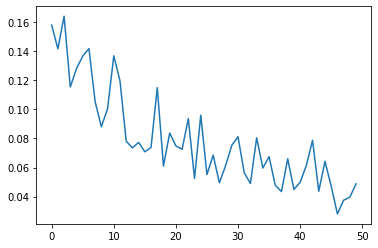

In [ ]:
plot_losses(losses);

In [ ]:
evaluate_randomly(test_loader, best_overall, i2w_inp, i2w_out, n=3)

> walk after walk opposite right
= I_TURN_RIGHT I_TURN_RIGHT I_WALK I_WALK
< I_TURN_RIGHT I_TURN_RIGHT I_WALK I_WALK

> turn opposite left twice and run thrice
= I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_RUN I_RUN
< I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_RUN I_RUN

> turn right and turn left twice
= I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT
< I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT



In [ ]:
test_acc(test_loader, best_overall, i2w_out)

0.8835485413677666

## Experiment 2

In [ ]:
train_loader, test_loader, i2w_inp, i2w_out = create_loaders('length_split/tasks_train_length.txt',
                                                             'length_split/tasks_test_length.txt',
                                                            batch_size=16)

In [ ]:
best_2 = EncoderDecoderModel(len(i2w_inp), len(i2w_out),
                              hidden_size=50, num_layers=1, max_length=MAX_LENGTH,
                              dropout=0.5, rnn_type=nn.GRU, attn=True)

In [ ]:
losses = train_iters(best_2, 100000, print_every=4000, plot_every=4000)

In [ ]:
plot_losses(losses)

In [ ]:
evaluate_randomly(test_loader, best_2, i2w_inp, i2w_out, n=10)

In [ ]:
test_acc(test_loader, best_2, i2w_out)

In [ ]:
#Overall Best

In [ ]:
best_2_overall = EncoderDecoderModel(len(i2w_inp), len(i2w_out),
                            hidden_size=50, num_layers=1, max_length=MAX_LENGTH,
                            dropout=0.5, rnn_type=nn.GRU, attn=True)

In [ ]:
losses = train_iters(best_2_overall, 100000, print_every=4000, plot_every=4000)
plot_losses(losses)


In [ ]:
evaluate_randomly(test_loader, best_2_overall, i2w_inp, i2w_out, n=10)

In [ ]:
test_acc(test_loader, best_2_overall, i2w_out)


In [ ]:
PATH = "/content/drive/My Drive/Advanced NLP/Final/best_2_overall_100000_1.pth"      # .pth or .pt is the conventional file extension for saving PyTorch models
torch.save(best_2_overall, PATH)

model_2_overall = torch.load(PATH)

In [ ]:
act_seq_len=[24,25,26,27,28,30,32,33,36,40,48]
results_2_overall=[]
for i in act_seq_len:
  results_2_overall.append( test_acc_act_seq_len(test_loader, model_2_overall, i2w_out,i))
results_2_overall


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(act_seq_len,results_2_overall)
plt.show()


In [ ]:
com_len=[4,6,7,8,9]
results_2_overall_2=[]
for i in com_len:
  results_2_overall_2.append( test_acc_com_len(test_loader, model_2_overall, i2w_out,i))
results_2_overall_2

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(com_len,results_2_overall_2)
plt.show()

In [ ]:
## TODO load new data, retrain the overall best model, the best one for this, accuracies, etc

TODO

## Experiment 3.1 (turn-left)

In [ ]:
train_loader, test_loader, i2w_inp, i2w_out = create_loaders(
    'add_prim_split/tasks_train_addprim_turn_left.txt',
    'add_prim_split/tasks_test_addprim_turn_left.txt')

In [ ]:
best_3 = EncoderDecoderModel(len(i2w_inp), len(i2w_out),
                              hidden_size=100, num_layers=1, max_length=MAX_LENGTH,
                              dropout=0.1, rnn_type=nn.GRU, attn=True)

/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
losses_3 = train_iters(best_3, 20000, print_every=400, plot_every=400)

#losses_3 = train_iters(best_3, 100000, print_every=2000, plot_every=200)

0m 15s (- 12m 27s) (400 2%) 1.3254
0m 27s (- 10m 54s) (800 4%) 0.9646
0m 39s (- 10m 16s) (1200 6%) 0.8739
0m 51s (- 9m 46s) (1600 8%) 0.7533
1m 2s (- 9m 24s) (2000 10%) 0.7422
1m 14s (- 9m 8s) (2400 12%) 0.6766
1m 26s (- 8m 52s) (2800 14%) 0.6414
1m 38s (- 8m 39s) (3200 16%) 0.5786
1m 51s (- 8m 26s) (3600 18%) 0.5054
2m 3s (- 8m 12s) (4000 20%) 0.4854
2m 15s (- 8m 0s) (4400 22%) 0.4362
2m 26s (- 7m 45s) (4800 24%) 0.4476
2m 39s (- 7m 32s) (5200 26%) 0.4340
2m 51s (- 7m 20s) (5600 28%) 0.3583
3m 3s (- 7m 7s) (6000 30%) 0.3895
3m 15s (- 6m 54s) (6400 32%) 0.3295
3m 27s (- 6m 42s) (6800 34%) 0.3057
3m 39s (- 6m 30s) (7200 36%) 0.3119
3m 52s (- 6m 19s) (7600 38%) 0.3259
4m 4s (- 6m 6s) (8000 40%) 0.2938
4m 16s (- 5m 54s) (8400 42%) 0.2634
4m 28s (- 5m 41s) (8800 44%) 0.2487
4m 40s (- 5m 29s) (9200 46%) 0.2361
4m 53s (- 5m 17s) (9600 48%) 0.2597
5m 5s (- 5m 5s) (10000 50%) 0.2433
5m 18s (- 4m 54s) (10400 52%) 0.2766
5m 30s (- 4m 41s) (10800 54%) 0.2248
5m 42s (- 4m 28s) (11200 56%) 0.2329
5

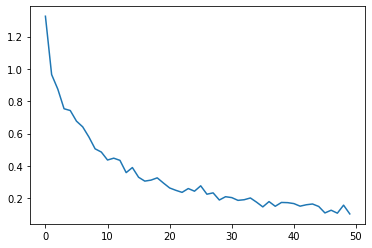

In [ ]:
plot_losses(losses_3)
#plt.savefig('Figures/plot_losses_best3_leftturn.png');

In [ ]:
evaluate_randomly(test_loader, best_3, i2w_inp, i2w_out, n=3)

> <SOS> look around right twice and turn left twice
= <SOS> I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT
< <SOS> I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

> <SOS> turn left after turn opposite left
= <SOS> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT
< <SOS> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

> <SOS> walk opposite left thrice and turn left
= <SOS> I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT
< <SOS> I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT



In [ ]:
test_acc(test_loader, best_3, i2w_out)

0.37748344370860926

In [ ]:
#torch.save(best_3, 'Trained models/best_3_leftturn.pth')
#torch.save(losses_3, 'Trained models/losses_3_leftturn.pth')

**Best overall**

In [ ]:
best_overall_31 = EncoderDecoderModel(len(i2w_inp), len(i2w_out),
                                   hidden_size=200, num_layers=2, max_length=MAX_LENGTH,
                                   dropout=0.5, rnn_type=nn.LSTM, attn=False)

In [ ]:
losses_31_bestoverall = train_iters(best_overall_31, 100000, print_every=2000, plot_every=200)


In [ ]:
plot_losses(losses_31_bestoverall);
plt.savefig('Figures/plot_losses_bestoverall_leftturn.png')

In [ ]:
evaluate_randomly(test_loader, best_overall_31, i2w_inp, i2w_out, n=3)

In [ ]:
test_acc(test_loader, best_overall_31, i2w_out)

In [ ]:
torch.save(best_overall_31, 'Trained models/bestoverall_leftturn.pth')
torch.save(losses_31_bestoverall, 'Trained models/losses_bestoverall_leftturn.pth')

## Experiment 3.2 (jump)

In [ ]:
train_loader, test_loader, i2w_inp, i2w_out = create_loaders(
    'add_prim_split/tasks_train_addprim_jump.txt',
    'add_prim_split/tasks_test_addprim_jump.txt')

In [ ]:
best_3_jump = EncoderDecoderModel(len(i2w_inp), len(i2w_out),
                                  hidden_size=100, num_layers=1, max_length=MAX_LENGTH,
                                  dropout=0.1, rnn_type=nn.LSTM, attn=True)

/shared-libs/python3.7/py/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
losses_3_jump = train_iters(best_3_jump, 20000, print_every=400, plot_every=400)

#losses_3_jump = train_iters(best_3_jump, 100000, print_every=2000, plot_every=200)

0m 37s (- 30m 18s) (400 2%) 1.2917
1m 2s (- 25m 0s) (800 4%) 0.9001
1m 18s (- 20m 28s) (1200 6%) 0.8177
1m 31s (- 17m 27s) (1600 8%) 0.7681
1m 43s (- 15m 28s) (2000 10%) 0.6668
2m 2s (- 14m 56s) (2400 12%) 0.6167
2m 18s (- 14m 9s) (2800 14%) 0.5368
2m 30s (- 13m 11s) (3200 16%) 0.4998
2m 42s (- 12m 22s) (3600 18%) 0.4765
2m 55s (- 11m 40s) (4000 20%) 0.4520
3m 9s (- 11m 12s) (4400 22%) 0.4075
3m 24s (- 10m 49s) (4800 24%) 0.4398
3m 37s (- 10m 17s) (5200 26%) 0.3977
3m 50s (- 9m 53s) (5600 28%) 0.4276
4m 2s (- 9m 26s) (6000 30%) 0.3545
4m 15s (- 9m 2s) (6400 32%) 0.3451
4m 28s (- 8m 40s) (6800 34%) 0.3039
4m 40s (- 8m 19s) (7200 36%) 0.3424
4m 52s (- 7m 57s) (7600 38%) 0.2872
5m 5s (- 7m 38s) (8000 40%) 0.3248
5m 17s (- 7m 18s) (8400 42%) 0.2815
5m 30s (- 7m 1s) (8800 44%) 0.2915
5m 43s (- 6m 42s) (9200 46%) 0.2345
5m 55s (- 6m 25s) (9600 48%) 0.2905
6m 8s (- 6m 8s) (10000 50%) 0.2634
6m 21s (- 5m 52s) (10400 52%) 0.2510
6m 33s (- 5m 35s) (10800 54%) 0.2414
6m 45s (- 5m 18s) (11200 56%)

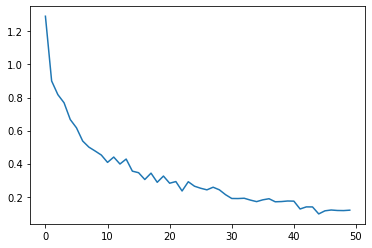

In [ ]:
plot_losses(losses_3_jump)
#plt.savefig('Figures/plot_losses_best3_jump.png');

In [ ]:
evaluate_randomly(test_loader, best_3_jump, i2w_inp, i2w_out, n=3)

> <SOS> look around left after jump around left
= <SOS> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK
< <SOS> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK

> <SOS> jump around left twice after walk opposite right thrice
= <SOS> I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP
< <SOS> I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK

> <SOS> walk o

In [ ]:
test_acc(test_loader, best_3_jump, i2w_out)

0.0014274591227614846

In [ ]:
#torch.save(best_3_jump, 'Trained models/best_3_jump.pth')
#torch.save(losses_3_jump, 'Trained models/losses_3_jump.pth')

**Best overall**

In [ ]:
best_overall_32 = EncoderDecoderModel(len(i2w_inp), len(i2w_out),
                                   hidden_size=200, num_layers=2, max_length=MAX_LENGTH,
                                   dropout=0.5, rnn_type=nn.LSTM, attn=False)

In [ ]:
losses_32_bestoverall = train_iters(best_overall_32, 20000, print_every=400, plot_every=400)


0m 29s (- 23m 52s) (400 2%) 1.3518
0m 54s (- 21m 39s) (800 4%) 1.0828
1m 20s (- 21m 2s) (1200 6%) 0.7948
1m 46s (- 20m 24s) (1600 8%) 0.6845
2m 11s (- 19m 43s) (2000 10%) 0.6308
2m 36s (- 19m 9s) (2400 12%) 0.5634
3m 1s (- 18m 37s) (2800 14%) 0.4810
3m 26s (- 18m 5s) (3200 16%) 0.4458
3m 52s (- 17m 38s) (3600 18%) 0.4239
4m 17s (- 17m 10s) (4000 20%) 0.3944
4m 44s (- 16m 48s) (4400 22%) 0.3811
5m 9s (- 16m 19s) (4800 24%) 0.3931
5m 34s (- 15m 51s) (5200 26%) 0.3227
6m 1s (- 15m 28s) (5600 28%) 0.3008
6m 26s (- 15m 2s) (6000 30%) 0.3308
6m 51s (- 14m 35s) (6400 32%) 0.3198
7m 16s (- 14m 7s) (6800 34%) 0.2949
7m 42s (- 13m 43s) (7200 36%) 0.2642
8m 8s (- 13m 17s) (7600 38%) 0.2772
8m 34s (- 12m 51s) (8000 40%) 0.2893
9m 1s (- 12m 27s) (8400 42%) 0.2503
9m 25s (- 11m 59s) (8800 44%) 0.2295
9m 53s (- 11m 36s) (9200 46%) 0.2230
10m 18s (- 11m 9s) (9600 48%) 0.2140
10m 46s (- 10m 46s) (10000 50%) 0.2575
11m 11s (- 10m 19s) (10400 52%) 0.2097
11m 37s (- 9m 54s) (10800 54%) 0.1925
12m 6s (- 9m

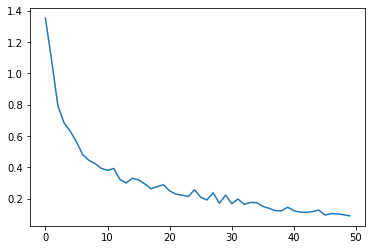

In [ ]:
plot_losses(losses_32_bestoverall)
#plt.savefig('Figures/plot_losses_bestoverall32_jump.png');

In [ ]:
evaluate_randomly(test_loader, best_overall_32, i2w_inp, i2w_out, n=3)

> <SOS> run twice after jump opposite left
= <SOS> I_TURN_LEFT I_TURN_LEFT I_JUMP I_RUN I_RUN
< <SOS> I_TURN_LEFT I_TURN_LEFT I_WALK I_RUN I_RUN

> <SOS> walk thrice and jump opposite right
= <SOS> I_WALK I_WALK I_WALK I_TURN_RIGHT I_TURN_RIGHT I_JUMP
< <SOS> I_WALK I_WALK I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK

> <SOS> turn left twice after jump right thrice
= <SOS> I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT
< <SOS> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT



In [ ]:
test_acc(test_loader, best_overall_32, i2w_out)

0.0

In [ ]:
#torch.save(best_overall_32, 'Trained models/bestoverall_3_jump.pth')
#torch.save(losses_32_bestoverall, 'Trained models/lossesoverall_3_jump.pth')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0553e0ac-0d27-456b-ad2a-70b39dd058c4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>